# Deep Transfer Learning for Text Classification

Handling tough real-world problems in Natural Language Processing (NLP) include tackling with class imbalance and the lack of availability of enough labeled data for training. Thanks to the recent advancements in deep transfer learning in NLP, we have been able to make rapid strides in not only tackling these problems but also leverage these models for diverse downstream NLP tasks.

The intent of this demo session is to look at various SOTA models in deep transfer learning for NLP with hands-on examples:

- Pre-trained word embeddings for Deep Learning Models (FastText with CNNs)
- Universal Embeddings (Sentence Encoders, NNLMs)
- Transformers (BERT, DistilBERT)

We will take a benchmark classification dataset and train and compare the performance of these models. All examples here will be showcased using Python and leveraging the latest and best of TensorFlow 2.x.

### Powered By

![](https://i.imgur.com/cllEHm0.png)

<div style="text-align: right; font-size:80%"><i>Tutorial by: [Dipanjan (DJ) Sarkar</i>](https://www.linkedin.com/in/dipanzan)</div>


# GPU Check

In [ ]:
!nvidia-smi

Sun Aug  9 09:54:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Necessary Dependencies

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import transformers
import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("TF Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
TF Hub version:  0.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


# Load and View Dataset

This is the [IMDB Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) for binary sentiment classification containing substantially more data than previous benchmark datasets. It provides a set of 25,000 highly polar movie reviews for training, and 25,000 for testing.

In [ ]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset['sentiment'] = [1 if record == 'positive' else 0 for record in dataset['sentiment']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Preparing Train, Validation and Test Datasets

Following is the dataset scheme we will use for modeling to simulate a small labeled dataset problem

- __Train Dataset:__ 5000 Reviews
- __Validation Dataset:__ 5000 Reviews
- __Test Dataset:__ 40000 Reviews

Thus we will be training all our models on only 5000 reviews and testing model performance on 40000 reviews!

In [ ]:
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:5000]
val_reviews = reviews [5000:10000]
test_reviews = reviews[10000:]



train_sentiments = sentiments[:5000]
val_sentiments = sentiments [5000:10000]
test_sentiments = sentiments[10000:]

train_reviews.shape, val_reviews.shape, test_reviews.shape

((5000,), (5000,), (40000,))

# Basic Text Pre-processing

We do minimal text pre-processing here since we are using deep learning models and not count-based methods. Steps include the following:

- Removing HTML characters
- Converting accented characters
- Fixing contractions
- Removing special characters

__Note:__ For some models we don't use any pre-processing like BERT!

In [ ]:
!sudo pip3 install contractions
!sudo pip3 install textsearch
!sudo pip3 install tqdm
!sudo pip3 install nltk
!sudo pip3 install beautifulsoup4

import nltk
nltk.download('punkt')

     |████████████████████████████████| 245kB 6.5MB/s 
     |████████████████████████████████| 317kB 10.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81696 sha256=b8c9bb1edc8fb0ed9bfb5263474c114206f25505e09ac8cf99903ab3a8c68a76
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()  
        norm_docs.append(doc)
    return norm_docs

In [ ]:
%%time

norm_train_texts = pre_process_corpus(train_reviews)
norm_val_texts = pre_process_corpus(val_reviews)
norm_test_texts = pre_process_corpus(test_reviews)

100%|██████████| 40000/40000 [00:17<00:00, 2239.63it/s]

CPU times: user 22.3 s, sys: 214 ms, total: 22.5 s
Wall time: 22.4 s


# Model 0: Simple Baseline ML Model - Logistic Regression

## Feature Extraction with BOW Model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=False, min_df=2, max_df=1.0)

cv_train_features = cv.fit_transform(norm_train_texts)
cv_test_features = cv.transform(norm_test_texts)
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (5000, 21646)  Test features shape: (40000, 21646)


## Train the ML Model

In [ ]:
%%time

# Logistic Regression model on BOW features
from sklearn.linear_model import LogisticRegression

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# train model
lr.fit(cv_train_features, train_sentiments)

# predict on test data
lr_bow_predictions = lr.predict(cv_test_features)

CPU times: user 3.34 s, sys: 5.39 s, total: 8.73 s
Wall time: 2.25 s


## Predict and Test Model Performance

In [ ]:
print(classification_report(test_sentiments, lr_bow_predictions))
pd.DataFrame(confusion_matrix(test_sentiments, lr_bow_predictions))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     20028
           1       0.85      0.85      0.85     19972

    accuracy                           0.85     40000
   macro avg       0.85      0.85      0.85     40000
weighted avg       0.85      0.85      0.85     40000



,0,1
0,17006,3022
1,2935,17037


# Model 1: FastText Embeddings + CNN 

![](https://i.imgur.com/6Pk3Nrv.png)

Convolutional Neural Networks (CNNs) have also proven to be very effective in text classification besides computer vision tasks. The idea is to leverage embeddings as features for text data and apply convolutions and poolings on them.

## Tokenizing text to create vocabulary

In [ ]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_texts)
t.word_index['<PAD>'] = 0

In [ ]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      t.word_index['<UNK>'])

('unscarred', 39232) ('<PAD>', 0) 1


## Convert texts (sequences of words) to sequence of numeric ids

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_texts)
val_sequences = t.texts_to_sequences(norm_val_texts)
test_sequences = t.texts_to_sequences(norm_test_texts)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=39233
Number of Documents=5000


## Visualizing sentence length distribution

(0.0, 2000.0)

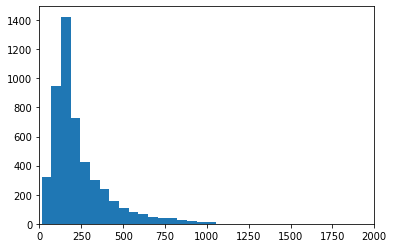

In [ ]:
plt.hist([len(doc.split()) for doc in norm_train_texts], bins=30);
plt.xlim([0, 2000])

## Padding text sequences

In [ ]:
MAX_SEQUENCE_LENGTH = 500

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((5000, 500), (40000, 500))

## Building FastText based Embedding Matrix

Here we will build an embedding matrix based on pre-trained FastText Embeddings available __[here](https://fasttext.cc/docs/en/english-vectors.html)__.

We will be using the __wiki-news-300d-1M-subword.vec.zip__ embedding file which has 1 million word vectors trained with subword infomation on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).

![](https://i.imgur.com/5de9N5R.png)

In [ ]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=128

## Download Pre-trained FastText Embeddings

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip

--2020-08-09 09:02:30--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5828358084 (5.4G) [application/zip]
Saving to: ‘crawl-300d-2M-subword.zip’

crawl-300d-2M-subwo 100%[===================>]   5.43G  31.4MB/s    in 2m 36s  

2020-08-09 09:05:07 (35.6 MB/s) - ‘crawl-300d-2M-subword.zip’ saved [5828358084/5828358084]



In [ ]:
!unzip crawl-300d-2M-subword.zip

Archive:  crawl-300d-2M-subword.zip
  inflating: crawl-300d-2M-subword.vec  
  inflating: crawl-300d-2M-subword.bin  


## Generate Pre-trained Embedding Matrix

In [ ]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './crawl-300d-2M-subword.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(39233, 300)

## Build Model Architecture

In [ ]:
# create the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=5))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=5))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=5))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          11769900  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 256)          384256    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 100, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 128)          163968    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 20, 64)            41024     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 64)            

## Train and Validate Model

In [ ]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, train_sentiments, 
          validation_data=(X_val, val_sentiments),
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/100
40/40 [==============================] - 5s 120ms/step - loss: 0.6961 - accuracy: 0.5060 - val_loss: 0.6919 - val_accuracy: 0.5130
Epoch 2/100
40/40 [==============================] - 5s 116ms/step - loss: 0.6735 - accuracy: 0.5770 - val_loss: 0.5773 - val_accuracy: 0.7478
Epoch 3/100
40/40 [==============================] - 5s 119ms/step - loss: 0.3613 - accuracy: 0.8498 - val_loss: 0.3068 - val_accuracy: 0.8758
Epoch 4/100
40/40 [==============================] - 5s 114ms/step - loss: 0.0785 - accuracy: 0.9750 - val_loss: 0.4029 - val_accuracy: 0.8642
Epoch 5/100
40/40 [==============================] - 5s 115ms/step - loss: 0.0181 - accuracy: 0.9936 - val_loss: 0.8480 - val_accuracy: 0.8402
Epoch 00005: early stopping


## Model Performance Evaluation on the Test Dataset

In [ ]:
predictions = model.predict_classes(X_test, batch_size=2048, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 86.92%
              precision    recall  f1-score   support

           0       0.90      0.84      0.86     20028
           1       0.85      0.90      0.87     19972

    accuracy                           0.87     40000
   macro avg       0.87      0.87      0.87     40000
weighted avg       0.87      0.87      0.87     40000



,0,1
0,16729,3299
1,1933,18039


# Model 2: Neural Network Language Model

![](https://i.imgur.com/blaLxUp.png)

## Sample training data

In [ ]:
norm_train_texts[:3]

['one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows would not dare forget pr

## Build a NNLM Embedding Layer 

In [ ]:
model = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(model, output_shape=[128], input_shape=[], 
                           dtype=tf.string, trainable=True)
print(hub_layer(np.array(norm_test_texts)[:3]))

tf.Tensor(
[[ 1.69656050e+00  4.13149334e-02  3.74761373e-02  1.33461043e-01
   9.40618813e-02 -7.07155913e-02  4.05320913e-01 -4.06657666e-01
  -1.36577681e-01  1.44075364e-01  2.72954047e-01 -5.80082715e-01
  -3.81301314e-01 -3.76442850e-01 -2.50549287e-01  2.52425373e-01
  -1.95503294e-01  8.17240253e-02 -3.05590719e-01  8.46153736e-01
   1.06243297e-01  9.39518586e-02 -1.55012712e-01 -1.16756044e-01
  -1.10410303e-01 -7.49441907e-02  2.51689196e-01 -7.85680711e-02
  -1.02299921e-01  1.44672930e-01 -9.27052945e-02  1.92560032e-01
   2.64064312e-01  9.82361212e-02  2.86211848e-01  2.62688790e-02
  -2.03817591e-01 -3.01025271e-01  2.66649108e-02  4.76490796e-01
  -3.97556275e-01  3.57046910e-02 -3.41935046e-02 -1.91338345e-01
   1.20033152e-01  1.56578079e-01  2.22025618e-01 -3.13825300e-03
   5.55458106e-02  4.36265509e-05  1.57775983e-01  9.02760774e-02
  -3.06066662e-01  1.30464703e-01 -3.88150394e-01 -2.14023113e-01
  -6.98908418e-02 -1.04502827e-01  3.52967111e-03  1.87276546e-02

## Build Model Architecture

In [ ]:
model = tf.keras.models.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 124,675,841
Trainable params: 124,675,841
Non-trainable params: 0
________________________________________

## Train and Validate Model

In [ ]:
EPOCHS=100
BATCH_SIZE=128

In [ ]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)
    
model.fit(np.array(norm_train_texts), train_sentiments, 
          validation_data=(np.array(norm_val_texts), val_sentiments),
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/100
40/40 [==============================] - 2s 59ms/step - loss: 0.5938 - accuracy: 0.6900 - val_loss: 0.4319 - val_accuracy: 0.8042
Epoch 2/100
40/40 [==============================] - 2s 52ms/step - loss: 0.3075 - accuracy: 0.8782 - val_loss: 0.3178 - val_accuracy: 0.8644
Epoch 3/100
40/40 [==============================] - 2s 53ms/step - loss: 0.1295 - accuracy: 0.9556 - val_loss: 0.3148 - val_accuracy: 0.8802
Epoch 4/100
40/40 [==============================] - 2s 45ms/step - loss: 0.0444 - accuracy: 0.9886 - val_loss: 0.3749 - val_accuracy: 0.8814
Epoch 5/100
40/40 [==============================] - 2s 46ms/step - loss: 0.0134 - accuracy: 0.9982 - val_loss: 0.4246 - val_accuracy: 0.8766
Epoch 6/100
40/40 [==============================] - 2s 50ms/step - loss: 0.0040 - accuracy: 0.9996 - val_loss: 0.4707 - val_accuracy: 0.8754
Epoch 00006: early stopping


## Model Performance Evaluation on the Test Dataset

In [ ]:
predictions = model.predict_classes(np.array(norm_test_texts), batch_size=512, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 87.41%
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     20028
           1       0.86      0.89      0.88     19972

    accuracy                           0.87     40000
   macro avg       0.87      0.87      0.87     40000
weighted avg       0.87      0.87      0.87     40000



,0,1
0,17224,2804
1,2233,17739


# Model 3: Google's Universal Sentence Encoder

These models take as input English strings and
produce as output a fixed dimensional embedding
representation of the string.

It has two models for encoding
sentences into embedding vectors. 
- One makes use
of the transformer (Vaswani et al., 2017) architecture
- The other is formulated as a deep averaging network (DAN) (Iyyer et al., 2015)

__Methodology 1: Transformers__

- The transformer based sentence encoding model
constructs sentence embeddings using the encoding sub-graph of the transformer architecture
(Vaswani et al., 2017). 
- This sub-graph uses attention to compute context aware representations
of words in a sentence that take into account both
the ordering and identity of all the other words.
- The context aware word representations are converted to a fixed length sentence encoding vector
by computing the element-wise sum of the representations at each word position
- The encoder takes as input a lowercased (Penn TreeBank) PTB tokenized string
and outputs a 512 dimensional vector as the sentence embedding


__Methodology 2: Deep Averaging Network (DAN)__

- In the deep averaging network (DAN) (Iyyer et al.,
2015) the input embeddings for words and
bi-grams are first averaged together and then
passed through a feedforward deep neural network
(DNN) to produce sentence embeddings. 
- Similar to the Transformer encoder, the DAN encoder takes as input a lowercased PTB tokenized string and outputs a 512 dimensional sentence embedding.

__Training Methodology:__

The encoding model is designed to be as general purpose as possible. This is accomplished by using multi-task learning whereby a single encoding model is used to feed multiple downstream tasks. 

Unsupervised training data for the sentence encoding models are drawn from a variety of web sources. The sources are Wikipedia, web news,
web question-answer pages and discussion forums. We augment unsupervised learning with training on supervised data from the Stanford Natural Language Inference (SNLI) corpus.


![](https://i.imgur.com/HIeb3tY.png)

__Note:__ In the past Google hadn't updated the USE to be directly compatible with TensorFlow 2.0 hence we had to use some hacks to disable eager execution and leverage older TF 1.x for model building and training. But recently we were able to get our hands on a TF 2.x pre-trained model! 

## Sample training data

In [ ]:
train_reviews[:3]

array(["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

## Load USE model from TF Hub

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(module_url)

## Sample vectorization of training reviews

In [ ]:
message_embeddings = embed(train_reviews[:3])

message_embeddings, message_embeddings.shape

(<tf.Tensor: shape=(3, 512), dtype=float32, numpy=
 array([[ 0.0104961 , -0.00933642, -0.01038742, ...,  0.03042184,
          0.06999607, -0.04120087],
        [-0.04972332,  0.03313328,  0.03567478, ...,  0.01486318,
          0.07754304,  0.05096985],
        [ 0.01188182, -0.05448665,  0.0564001 , ...,  0.00985926,
          0.08284976,  0.04893022]], dtype=float32)>, TensorShape([3, 512]))

## Build a USE Embedding Layer

In [ ]:
model = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(model, output_shape=[512], input_shape=[], 
                           dtype=tf.string, trainable=True)
print(hub_layer(train_reviews[:3]))

tf.Tensor(
[[ 0.01049606 -0.00933641 -0.01038734 ...  0.03042187  0.06999607
  -0.04120094]
 [-0.04972334  0.03313329  0.0356748  ...  0.01486317  0.07754304
   0.05096984]
 [ 0.01188187 -0.05448666  0.05640008 ...  0.00985926  0.08284976
   0.04893022]], shape=(3, 512), dtype=float32)


## Build Model Architecture

In [ ]:
model = tf.keras.models.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 256,995,201
Trainable params: 256,995,201
Non-trainable params: 0
________________________________________

## Train and Validate Model

In [ ]:
EPOCHS=100
BATCH_SIZE=128

In [ ]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)
    
model.fit(train_reviews, train_sentiments, 
          validation_data=(val_reviews, val_sentiments),
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/100
40/40 [==============================] - 12s 312ms/step - loss: 0.4918 - accuracy: 0.7740 - val_loss: 0.3626 - val_accuracy: 0.8382
Epoch 2/100
40/40 [==============================] - 12s 303ms/step - loss: 0.1581 - accuracy: 0.9420 - val_loss: 0.3035 - val_accuracy: 0.8768
Epoch 3/100
40/40 [==============================] - 11s 284ms/step - loss: 0.0167 - accuracy: 0.9972 - val_loss: 0.4052 - val_accuracy: 0.8748
Epoch 4/100
40/40 [==============================] - 12s 292ms/step - loss: 9.8859e-04 - accuracy: 1.0000 - val_loss: 0.4473 - val_accuracy: 0.8782
Epoch 00004: early stopping


## Model Performance Evaluation on the Test Dataset

In [ ]:
predictions = model.predict_classes(test_reviews, batch_size=512, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 87.48%
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     20028
           1       0.87      0.88      0.87     19972

    accuracy                           0.87     40000
   macro avg       0.87      0.87      0.87     40000
weighted avg       0.87      0.87      0.87     40000



,0,1
0,17463,2565
1,2445,17527


# Model 4: BERT (Bi-directional Encoder Representations from Transformers)

![](https://i.imgur.com/RMuSvTL.png)

We will be using the BERT base model which has already been pre-trained by Google on MLM + Next Sentence Prediction Tasks

## BERT Tokenization

The BERT model we're using expects lowercase data. Here we leverage Huggingface `transformers`' `BertTokenizer`, which breaks words into word pieces.

Word Piece Tokenizer is based on [Byte Pair Encodings (BPE)](https://www.aclweb.org/anthology/P16-1162).

WordPiece and BPE are two similar and commonly used techniques to segment words into subword-level in NLP tasks. In both cases, the vocabulary is initialized with all the individual characters in the language, and then the most frequent/likely combinations of the symbols in the vocabulary are iteratively added to the vocabulary.

magine that the model sees the word walking. Unless this word occurs at least a few times in the training corpus, the model can't learn to deal with this word very well. However, it may have the words walked, walker, walks, each occurring only a few times. Without subword segmentation, all these words are treated as completely different words by the model.

However, if these get segmented as walk@@ ing, walk@@ ed, etc., notice that all of them will now have walk@@ in common, which will occur much frequently while training, and the model might be able to learn more about it.

Huggingface's transformers library has easy to use utilities for each type of model

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

## BERT Data Preparation

We need to preprocess our data so that it matches the data format BERT was trained on. For this, we'll need to do a couple of things.

- Lowercase our text (if we're using a BERT lowercase model)
- Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
- Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
- Map our words to indexes using a vocab file that BERT provides
- Add special "CLS" and "SEP" tokens (see the readme)
- Append "mask" and "segment" tokens to each input (see the BERT paper)

In [ ]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        segments = [0] * max_seq_length
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)
        
    encoded = np.array([all_ids, all_masks, all_segments])
    
    return encoded

## Build Model Architecture

![](https://i.imgur.com/ZtxlKiQ.png)

In [ ]:
MAX_SEQ_LENGTH = 500

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")
inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 500)]        0                                            
__________________________________________________________________________________________________
bert_segment_ids (InputLayer)   [(None, 500)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 500, 768), ( 109482240   bert_input_ids[0][0]             
                                                                 bert_input_masks[0][0]

## Convert text to BERT input features

![](https://i.imgur.com/3Le7Kyk.png)

We leverage our utility function we created earlier to convert our text reviews into BERT input features.

In [ ]:
train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer, 
                                                                                               train_reviews, 
                                                                                               max_seq_length=MAX_SEQ_LENGTH)
val_features_ids, val_features_masks, val_features_segments = create_bert_input_features(tokenizer, 
                                                                                         val_reviews, 
                                                                                         max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape, train_features_segments.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape, val_features_segments.shape)

Converting docs to features: 100%|██████████| 5000/5000 [00:15<00:00, 320.05it/s]

Train Features: (5000, 500) (5000, 500) (5000, 500)
Val Features: (5000, 500) (5000, 500) (5000, 500)


## Train and Validate Model

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=1,
                                      restore_best_weights=True,
                                      verbose=1)
model.fit([train_features_ids, 
           train_features_masks, 
           train_features_segments], train_sentiments, 
          validation_data=([val_features_ids, 
                            val_features_masks, 
                            val_features_segments], val_sentiments),
          epochs=3, 
          batch_size=13, 
          callbacks=[es],
          shuffle=True,
          verbose=1)

Epoch 1/3
385/385 [==============================] - 435s 1s/step - loss: 0.3430 - accuracy: 0.8460 - val_loss: 0.2368 - val_accuracy: 0.9116
Epoch 2/3
385/385 [==============================] - 432s 1s/step - loss: 0.1550 - accuracy: 0.9478 - val_loss: 0.2176 - val_accuracy: 0.9222
Epoch 3/3
385/385 [==============================] - 432s 1s/step - loss: 0.0857 - accuracy: 0.9720 - val_loss: 0.3227 - val_accuracy: 0.9092
Epoch 00003: early stopping


In [ ]:
model.save_weights('bert_ft_wts.h5')

## Convert Test reviews to BERT input features

In [ ]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer, 
                                                                                            test_reviews, 
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Converting docs to features: 100%|██████████| 40000/40000 [02:06<00:00, 316.95it/s]


Test Features: (40000, 500) (40000, 500) (40000, 500)


## Model Performance Evaluation on the Test Dataset

In [ ]:
predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks, 
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 92.04%
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     20028
           1       0.91      0.94      0.92     19972

    accuracy                           0.92     40000
   macro avg       0.92      0.92      0.92     40000
weighted avg       0.92      0.92      0.92     40000



,0,1
0,18113,1915
1,1269,18703


# Model 5: DistilBERT (Distilled BERT)

![](https://i.imgur.com/FzCb8yM.png)

![](https://i.imgur.com/X9Rvjrn.png)

## BERT Tokenization

The DistilBERT model we're using expects lowercase data. Here we leverage Huggingface `transformers`' `DistilBertTokenizer`, which breaks words into word pieces.

Word Piece Tokenizer is based on [Byte Pair Encodings (BPE)](https://www.aclweb.org/anthology/P16-1162).

WordPiece and BPE are two similar and commonly used techniques to segment words into subword-level in NLP tasks. In both cases, the vocabulary is initialized with all the individual characters in the language, and then the most frequent/likely combinations of the symbols in the vocabulary are iteratively added to the vocabulary.

magine that the model sees the word walking. Unless this word occurs at least a few times in the training corpus, the model can't learn to deal with this word very well. However, it may have the words walked, walker, walks, each occurring only a few times. Without subword segmentation, all these words are treated as completely different words by the model.

However, if these get segmented as walk@@ ing, walk@@ ed, etc., notice that all of them will now have walk@@ in common, which will occur much frequently while training, and the model might be able to learn more about it.

Huggingface's transformers library has easy to use utilities for each type of model

In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

## DistilBERT Data Preparation

We need to preprocess our data so that it matches the data format DistilBERT was trained on. For this, we'll need to do a couple of things.

- Lowercase our text (if we're using a BERT lowercase model)
- Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
- Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
- Map our words to indexes using a vocab file that BERT provides
- Add special "CLS" and "SEP" tokens (see the readme)
- Append "mask" tokens to each input (see https://medium.com/huggingface/distilbert-8cf3380435b5)

In [ ]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        all_ids.append(ids)
        all_masks.append(masks)
        
    encoded = np.array([all_ids, all_masks])
    
    return encoded

## Build Model Architecture

In [ ]:
MAX_SEQ_LENGTH = 500

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inputs = [inp_id, inp_mask]

hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
pooled_output = hidden_state[:, 0]    
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)


model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 500)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti ((None, 500, 768),)  66362880    bert_input_ids[0][0]             
                                                                 bert_input_masks[0][0]           
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 768)]        0           tf_distil_bert_model_1

## Convert text to DistilBERT input features

In [ ]:
train_features_ids, train_features_masks = create_bert_input_features(tokenizer, train_reviews, 
                                                                      max_seq_length=MAX_SEQ_LENGTH)
val_features_ids, val_features_masks = create_bert_input_features(tokenizer, val_reviews, 
                                                                  max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape)

Converting docs to features: 100%|██████████| 5000/5000 [00:15<00:00, 323.71it/s]


Train Features: (5000, 500) (5000, 500)
Val Features: (5000, 500) (5000, 500)


## Train and Validate Model

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=1,
                                      restore_best_weights=True,
                                      verbose=1)
model.fit([train_features_ids, 
           train_features_masks], train_sentiments, 
          validation_data=([val_features_ids, 
                            val_features_masks], val_sentiments),
          epochs=3, 
          batch_size=20, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/3
250/250 [==============================] - 205s 819ms/step - loss: 0.3526 - accuracy: 0.8322 - val_loss: 0.2577 - val_accuracy: 0.8982
Epoch 2/3
250/250 [==============================] - 204s 816ms/step - loss: 0.1774 - accuracy: 0.9362 - val_loss: 0.2380 - val_accuracy: 0.9030
Epoch 3/3
250/250 [==============================] - 204s 815ms/step - loss: 0.0898 - accuracy: 0.9716 - val_loss: 0.2929 - val_accuracy: 0.9040
Epoch 00003: early stopping


In [ ]:
model.save_weights('distillbert_ft_wts.h5')

## Convert Test reviews to BERT input features

In [ ]:
test_features_ids, test_features_masks = create_bert_input_features(tokenizer, test_reviews, 
                                                                    max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape)

Converting docs to features: 100%|██████████| 40000/40000 [02:04<00:00, 321.16it/s]

Test Features: (40000, 500) (40000, 500)


## Model Performance Evaluation on the Test Dataset

In [ ]:
predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks], batch_size=200, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 91.03%
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     20028
           1       0.91      0.91      0.91     19972

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000



,0,1
0,18164,1864
1,1722,18250
